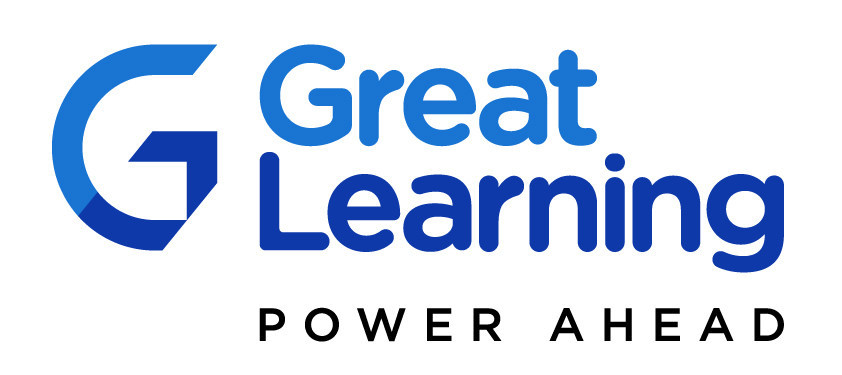

# **MLS 2: Text Preprocessing - Working with Text Data**
## **Fake News Detector** w/ Content-based vs Hybrid Feature + Content Text Classification

In this notebook - we will not just use the ideas of Text Preprocessing and Text Vectorization to create the typical Machine Learning NLP pipeline. **Rather, we combine ideas from Tabular Machine Learning and NLP, and create a hybrid Feature + Content Text Classifier** that utilizes both text content as well as tabular metadata features about the content. We will show that our hybrid classifier can achieve improved Text Classification performance in a Fake News Detection problem statement, than a pure content-based text classifier.

This demonstration has important implications for the apparent best practices in industry-standard NLP - **the best solution often tends to be a hybrid / Ensemble approach that combines the best of multiple methods**, and this is an idea that we need to keep in mind as we delve into newer, more powerful techniques as well - using them in combination with older techniques (rather than replacing them entirely), can often give us the best results.

## **Fake News Detection - Problem Statement**
With the rise of social media and the internet, fake news has become a prevalent issue in our society. Fake news can spread rapidly, causing widespread panic and even affecting political decisions. As a result, detecting and combating fake news has become crucial. Fake news can have severe consequences for businesses, governments, and society as a whole - by detecting it accurately, businesses can avoid making decisions based on false information and prevent potential damage to their reputation.

Fake news can be challenging to detect because it is often written in a way that mimics real news.

This project aims to use Machine Learning models in a classical NLP pipeline to attempt to accurately detect fake news.

## **Dataset Details**
The dataset contains the following columns:
- Serial number (starting from 0)
- text
- len_of_text
- word_count
- unique_word_count
- **Label (0 = fake and 1 = real)**

## **Importing the necessary libraries**

In [1]:
# Import the necessary libraries
import pandas as pd                                          # Library for data manipulation
from sklearn.feature_extraction.text import TfidfVectorizer  # Text feature extraction (TF-IDF)
from sklearn.ensemble import RandomForestClassifier          # Random Forest classifier
from sklearn.model_selection import train_test_split         # Data splitting for training and testing
from sklearn.metrics import accuracy_score, f1_score ,classification_report  # Evaluation metrics
import string                                                # String manipulation functions
from nltk.corpus import stopwords                            # Stopwords for text preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer                         # Lemmatization for text preprocessing
import nltk                                                  # Natural Language Toolkit
nltk.download('stopwords')                                   # Download stopwords dataset
nltk.download('wordnet')                                     # Download WordNet dataset
nltk.download('omw-1.4')                                     # Download Open Multilingual WordNet (OMW) dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


## **Loading the dataset**

In [2]:
data = pd.read_csv("/content/Fake_new_v1_dataset.csv")

In [3]:
data.head()

,Unnamed: 0,text,len_of_text,word_count,unique_word_count,label
0,0,"As France emergency rule ends, Macron defends ...",1923,301,192,0
1,1,Mother Calls Cops About Her Missing 12-Year-O...,2334,418,256,1
2,2,TRUMP SUPPORTERS REACT TO DEBATE: “Clinton New...,1910,272,193,1
3,3,"Trump to sign orders to renegotiate NAFTA, pul...",1733,279,176,0
4,4,IRONY ALERT! DC’S DAY WITHOUT WOMEN Literally ...,269,47,44,1


In [4]:
data.shape

(12499, 6)

**There are 12,499 rows and 6 columns.**

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12499 entries, 0 to 12498
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         12499 non-null  int64 
 1   text               12499 non-null  object
 2   len_of_text        12499 non-null  int64 
 3   word_count         12499 non-null  int64 
 4   unique_word_count  12499 non-null  int64 
 5   label              12499 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 586.0+ KB


- There are 6 columns in the dataset, each representing a different attribute or feature.
- The data types of the columns vary, with most columns being of integer type (int64) and one column containing text data (object).
- There are no missing values (non-null count equals the total number of entries) in any of the columns. This suggests that the dataset is complete, and there's no need for data imputation.

In [6]:
data.describe()

,Unnamed: 0,len_of_text,word_count,unique_word_count,label
count,12499.000000,12499.000000,12499.000000,12499.000000,12499.000000
mean,6249.000000,3371.964157,557.112649,303.157613,0.559965
std,3608.294842,3721.984923,621.830158,248.301740,0.496411
min,0.000000,19.000000,2.000000,1.000000,0.000000
25%,3124.500000,1500.500000,246.500000,163.000000,0.000000
50%,6249.000000,2503.000000,411.000000,250.000000,1.000000
75%,9373.500000,4114.000000,674.000000,375.000000,1.000000
max,12498.000000,99429.000000,17345.000000,4646.000000,1.000000


- The mean length of text is approximately 3372 characters.
- The minimum text length is 19 characters, suggesting the presence of very short texts.
- The maximum text length is 99,429 characters, indicating the existence of very long texts.
-The mean word count is approximately 557 words.
-The median word count (50th percentile) is 411 words, suggesting that half of the documents have fewer than 411 words.
- The maximum unique word count is 4,646, indicating documents with diverse vocabulary.
- The median unique word count (50th percentile) is 250 unique words
-The dataset's 25th and 75th percentiles are both 0 and 1, indicating a relatively even distribution between the two classes.

In [7]:
# checking for duplicate values
data.duplicated().sum()

0

## **Exploratory Data Analysis**

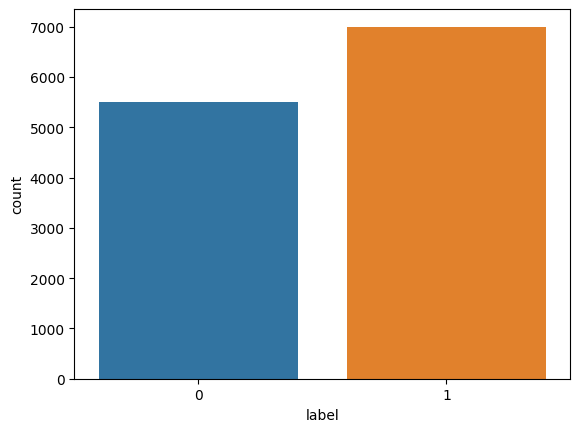

--------------------------------------------------
1    0.559965
0    0.440035
Name: label, dtype: float64


In [8]:
sns.countplot(x = 'label', data = data)
plt.show()

print("-"*50)

# checking the percentage of ham and spam messages
print(data['label'].value_counts(normalize = True))

The dataset exhibits a slight class imbalance, with about **44.00% labeled as 0 (Fake News), and 55.99% labeled as 1 (Real News).**

The Real News class (label 1) is slightly more prevalent in the dataset compared to the Fake News class (label 0).

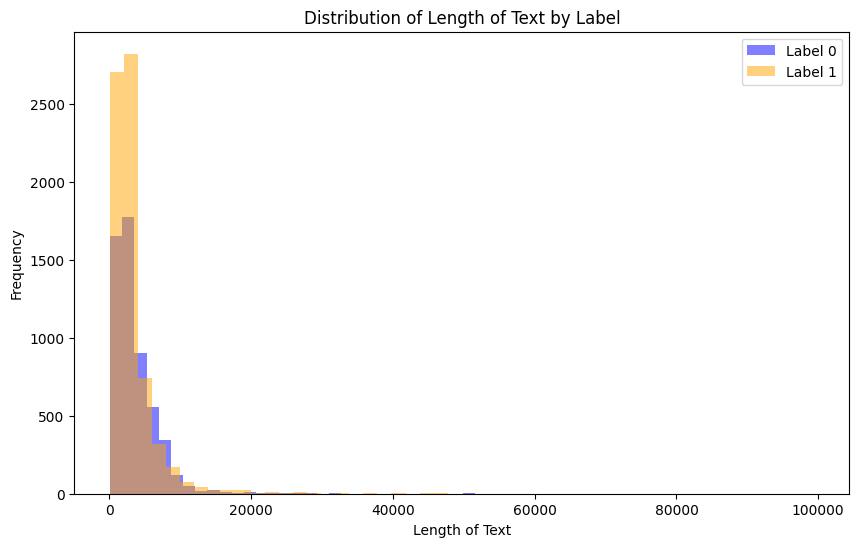

------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5500.0,3600.135818,3673.890671,82.0,1517.0,2700.5,4800.0,85994.0
1,6999.0,3192.660809,3749.878158,19.0,1485.5,2334.0,3582.0,99429.0


In [9]:
# Create a histogram for 'len_of_text' by label
plt.figure(figsize=(10, 6))
plt.hist(data[data['label'] == 0]['len_of_text'], bins=50, alpha=0.5, label='Label 0', color='blue')
plt.hist(data[data['label'] == 1]['len_of_text'], bins=50, alpha=0.5, label='Label 1', color='orange')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Length of Text by Label')
plt.show()

print ("------"*10)

data.groupby('label')['len_of_text'].describe()

**For Label 0 (Fake News):**

The average length of text is approximately 3600 characters.
The minimum text length is 82 characters, and the maximum is 85,994 characters.
The middle 50% of the data falls within the range of 1517 to 4800 characters.

**For Label 1 (Real News):**

The average length of text is approximately 3193 characters.
The minimum text length is 19 characters, and the maximum is 99,429 characters.
The middle 50% of the data falls within the range of 1485.5 to 3582 characters.

This EDA seems to suggest that **Fake News articles tend to have a slightly higher number of characters in the article than Real News** - an interesting insight.

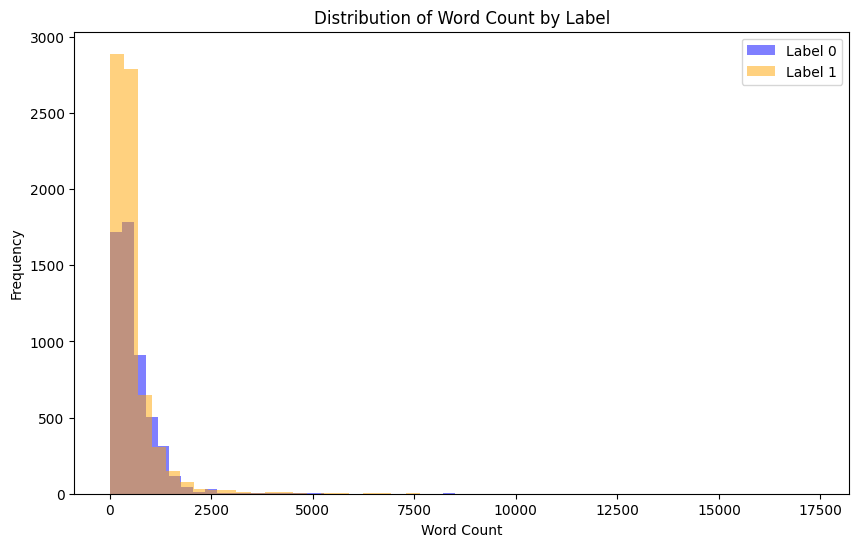

----------------------------------------


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,5500.0,594.882364,624.171181,11.0,248.0,437.0,790.0,14650.0
1,6999.0,527.432205,618.412210,2.0,245.0,391.0,593.0,17345.0


In [10]:
# Create a histogram for 'word_count' by label
plt.figure(figsize=(10, 6))
plt.hist(data[data['label'] == 0]['word_count'], bins=50, alpha=0.5, label='Label 0', color='blue')
plt.hist(data[data['label'] == 1]['word_count'], bins=50, alpha=0.5, label='Label 1', color='orange')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Word Count by Label')
plt.show()

print ("----"*10)

data.groupby('label')['word_count'].describe()

- **For Label 0 (Fake News):**

The average word count is approximately 595 words.
The minimum word count is 11 words, and the maximum is 14,650 words.
The middle 50% of the data falls within the range of 248 to 790 words.

- **For Label 1 (Real News):**

The average word count is approximately 527 words.
The minimum word count is 2 words, and the maximum is 17,345 words.
The middle 50% of the data falls within the range of 245 to 593 words.

Interestingly, while the lengthiest article is a Real News article, there appears to be **more variation in article word count among Fake News articles**. **The average word count is also higher for Fake News.**

**Let us look at the Top 100 Unique Words in the text column**

There are 42158678 words in the combination of all texts.


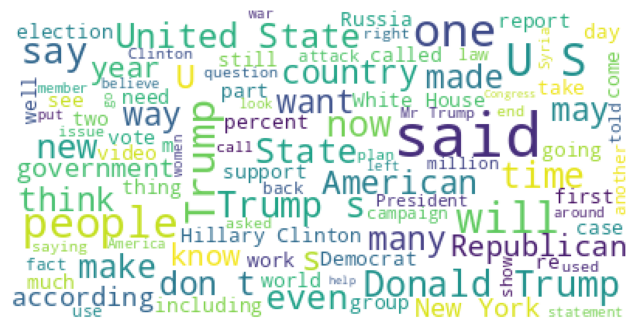

In [11]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
all_texts = " ".join(texts for texts in data.text)
print ("There are {} words in the combination of all texts.".format(len(all_texts)))

# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size = 40, max_words=100, background_color="white").generate(all_texts)
plt.figure(figsize=(8,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## **Let's look at some of the text in the data to get a sense for the Text Preprocessing required**

In [12]:
data.loc[0, 'text']

'As France emergency rule ends, Macron defends new anti-terrorism law STRASBOURG/PARIS (Reuters) - President Emmanuel Macron defended new security legislation on Tuesday, saying Islamist militants still posed a serious threat to France as a two-year state of emergency comes to an end. The anti-terrorism law, which critics say undermines civil liberties, takes effect on Wednesday, replacing the state of emergency that was imposed in November 2015, when militants killed 130 people in coordinated attacks across Paris. The law gives the police greater powers to search properties, conduct electronic eavesdropping and shut down mosques suspected of preaching hatred than they had prior to the state of emergency. Speaking to the European Court of Human Rights in Strasbourg, eastern France, Macron said  jihadist terrorism  remained the biggest security threat to France.  Terrorism targets European society and values just as it targets government and state. We are being attacked because of what 

In [13]:
data.loc[1000, 'text']

'Highlights: The Trump presidency on January 30 at 6:25 PM EST/2325 GMT WASHINGTON (Reuters) - Highlights of the day for U.S. President Donald Trump’s administration on Monday: Congressional Democrats and some foreign nations, including key U.S. allies, put pressure on Trump over his temporary ban on entry to America by refugees and people from seven predominantly Muslim countries. The Pentagon says it is making a list of Iraqis who worked alongside American troops. Democratic U.S. senators try to force a vote on a bill to rescind Trump’s order, but are blocked by a Republican lawmaker. Washington state announces a legal challenge to the ban and former President Barack Obama takes a swipe at his successor. The chief executives of Goldman Sachs Group Inc and Ford Motor Co join the criticism of Trump’s ban. Tens of thousands of people protest in London and other British cities against Trump’s ban. The United States should revoke “dangerous” new immigration measures, France’s foreign mini

## **Text Preprocessing**

The following preprocessing steps aim to standardize and clean the text data, making it more suitable for various natural language processing tasks such as text classification, sentiment analysis, or topic modeling. The cleaner and more structured representation of the original text, which can improve the performance of text-based machine learning models.

In [14]:
def preprocess_text(text):
    # 1. Lowercasing
    text = text.lower()

    # 2. Removing Punctuation
    text = ''.join([char for char in text if char not in string.punctuation])

    # 3. Tokenization (split the text into words)
    tokens = text.split()

    # 4. Removing Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

     # 5. Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # 5. Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]



    # 6. Join Tokens Back to Text
    text = ' '.join(tokens)

    return text

In [15]:
data['text'] =data['text'].apply(preprocess_text)

In [16]:
data.loc[0, 'text']

'franc emerg rule end macron defend new antiterror law strasbourgpari reuter presid emmanuel macron defend new secur legisl tuesday say islamist milit still pose seriou threat franc twoyear state emerg come end antiterror law critic say undermin civil liberti take effect wednesday replac state emerg impos novemb 2015 milit kill 130 peopl coordin attack across pari law give polic greater power search properti conduct electron eavesdrop shut mosqu suspect preach hatr prior state emerg speak european court human right strasbourg eastern franc macron said jihadist terror remain biggest secur threat franc terror target european societi valu target govern state attack stand said macron took offic may 240 peopl kill french soil islamistinspir attack almost three year dozen kill similar attack elsewher europ primarili britain belgium govern say state emerg help intellig agenc thwart 30 attack mani emerg power enshrin law draw critic human right group franc becom addict state emerg inject sever

In [17]:
data.loc[1000, 'text']

'highlight trump presid januari 30 625 pm est2325 gmt washington reuter highlight day u presid donald trump’ administr monday congression democrat foreign nation includ key u alli put pressur trump temporari ban entri america refuge peopl seven predominantli muslim countri pentagon say make list iraqi work alongsid american troop democrat u senat tri forc vote bill rescind trump’ order block republican lawmak washington state announc legal challeng ban former presid barack obama take swipe successor chief execut goldman sach group inc ford motor co join critic trump’ ban ten thousand peopl protest london british citi trump’ ban unit state revok “dangerous” new immigr measur france’ foreign minist say visit tehran un refuge agenc voic alarm trump’ decis suspend entri refuge say week alon 800 peopl set make america new home bar trump say announc nomine u suprem court tuesday night seek quickli put stamp court restor conserv major even democrat gear senat confirm fight senat democrat dela

## **Machine Learning Modeling - First Attempt**
### **Random Forest Model Building with the Preprocessed Text Column only**

In [18]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X = tfidf_vectorizer.fit_transform(data['text'])
y = data['label']

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)


Accuracy: 0.9168
F1-score: 0.929107021131561


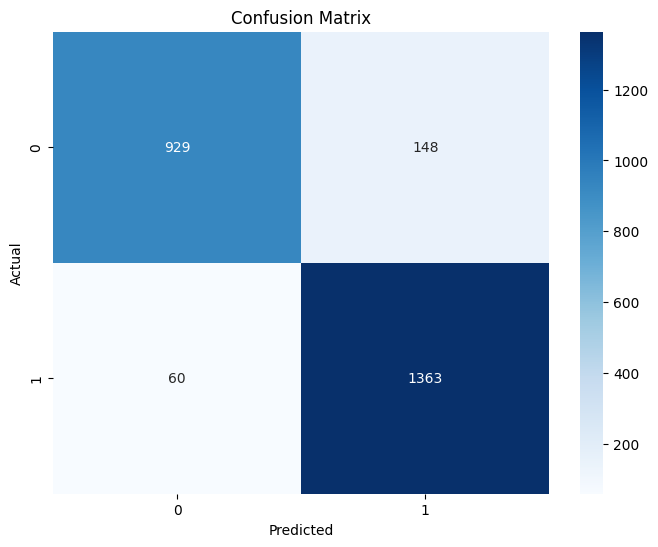

In [21]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- **The accuracy score of 91.68%** indicates that the model's predictions are quite good, considering the dataset is only slightly imbalanced.

- **The F1-score of 92.91%** is a measure of the balance between model's precision and recall, taking both false positives and false negatives into account. The high accuracy & F1-score suggests that the model strikes a good balance between correctly identifying positive and negative cases.

- However, **let's go beyond the typical NLP Machine Learning pipeline**, and see if we can **utilize the other metadata tabular features available to us about each article in combination with the TF-IDF vectors of text**, to improve the model accuracy.

## **Machine Learning Modeling - Second Attempt**
### **Random Forest Hybrid Model Building with both text and other features in the dataset**

In [22]:
data = pd.read_csv("/content/Fake_new_v1_dataset.csv")  ###Loading the dataset again

In [23]:
# Rename the 'label' column to 'target_column'
data.rename(columns={'label': 'target_column'}, inplace=True)

In [24]:
data['text'] =data['text'].apply(preprocess_text)

In [25]:
# Use TF-IDF vectorization for the 'text' column
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_text_tfidf = tfidf_vectorizer.fit_transform(data['text'])

In [26]:
# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X_text_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Merge the TF-IDF DataFrame with the original DataFrame
merged_df = pd.concat([data, tfidf_df], axis=1)

In [27]:
merged_df['target_column']

0        0
1        1
2        1
3        0
4        1
        ..
12494    1
12495    0
12496    0
12497    0
12498    1
Name: target_column, Length: 12499, dtype: int64

- **TF-IDF Vectorization:** The TfidfVectorizer from scikit-learn is used to convert the text data in the 'text' column of the data DataFrame into TF-IDF features. The max_features parameter is set to 5000, limiting the maximum number of features (words) to 5000. This step creates a TF-IDF matrix X_text_tfidf.

- **Converting TF-IDF Matrix to DataFrame:** The TF-IDF matrix X_text_tfidf is converted into a DataFrame named tfidf_df. This DataFrame has rows corresponding to the original data samples and columns corresponding to the TF-IDF features. The toarray() method is used to convert the sparse TF-IDF matrix into a dense array format.

- **Merging DataFrames:** The TF-IDF DataFrame (tfidf_df) is concatenated horizontally (along columns) with the original data DataFrame using pd.concat. This results in a new DataFrame named merged_df where the TF-IDF features are added as additional columns to the original data.

The shape of merged_df is (12499, 5006), it means that we have successfully added 5000 TF-IDF features to the original dataset, resulting in a total of 5006 columns (including the original columns from data). Each row in merged_df represents a sample from the original data with TF-IDF features appended.

In [28]:
# Define your features (X) and target variable (y)
X = merged_df.drop(columns=['Unnamed: 0', 'text', "target_column"])  # Drop the specified columns, since we already have text vectors we do not need text
y = merged_df['target_column']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# Build a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

Accuracy: 0.9332
F1-score: 0.9423939289410141


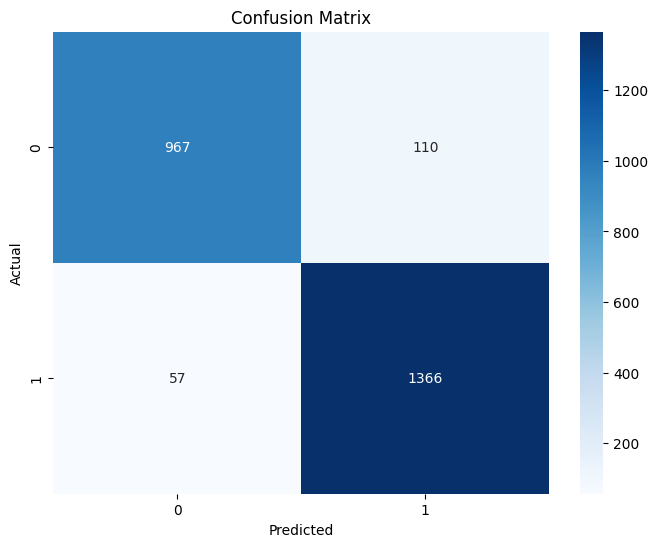

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- As we can see, both the **Accuracy (93.32% from 92.56%)** and the **F1-Score (94.24% from 93.59%)** have shown a slight improvement when taking into account the additional tabular features in combination with the TF-IDF vectors of the text content.

- This shows that when we're working with naïve / statistical text modeling techniques, there is value in **increasing the complexity of the model and using additional tabular features with respect to model performance.**


### **Feature Importance of Words to the Model**

In [34]:
# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to associate feature names with their importance scores
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Print or visualize the feature importances
print(importances_df)

         Feature  Importance
3780      reuter    0.076002
3880        said    0.046996
4772         via    0.014789
2286        imag    0.014268
4778       video    0.014065
...          ...         ...
2590  laboratori    0.000000
1458         dos    0.000000
2622     laureat    0.000000
3118       nusra    0.000000
4081    singapor    0.000000

[5002 rows x 2 columns]


- Interestingly, the word feature **"reuter"** has the highest importance with a score of 7.6%, with **"said"** also having relatively high importance with a score of 4.7% - these two words likely contribute to an article being a Real News article as opposed to a Fake News one.

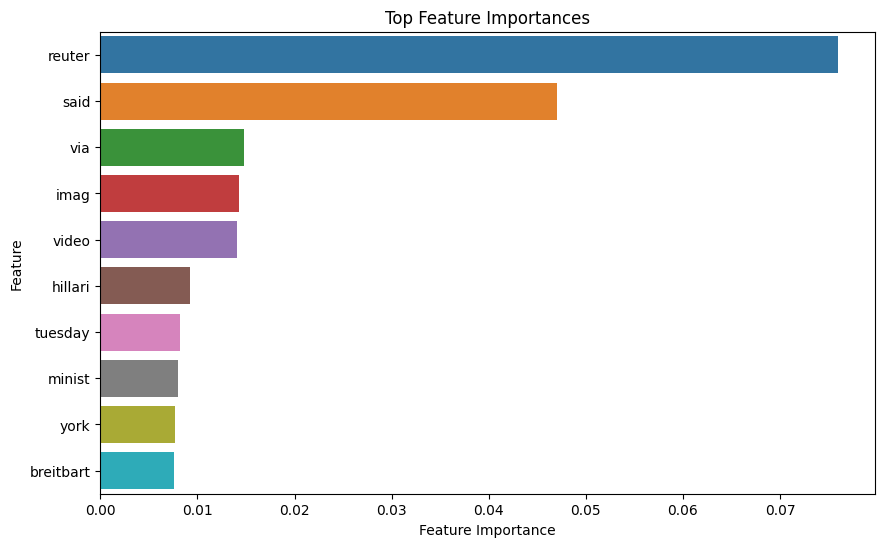

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(10))  # Display the top 10 features
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances')
plt.show()

## **Machine Learning Modeling - Third Attempt**
### **Stacked Meta-Learning Hybrid Modeling with both text and other features in the dataset**

**While we have exclusively used a Random Forest model for our Text Classification problems so far**, there are also potentially more powerful methods that we can trial to push up the model's complexity and performance even further.

**The approach we will follow is called Stacking**, an Ensemble idea where we take a set of base Machine Learning models, have each of them make predictions from the dataset in parallel, and the predictions from each of these act as **features to a second-level "meta-learning" Machine Learning model**.

**In this case, we will use a Logistic Regression (LR) model, a Random Forest (RF) model and a Support Vector Machine (SVM) model as the base models to an XGBoost meta-learning Machine Learning model.**

In the context of Stacked Meta-Learning, the base models (SVM, LR, RF) produce their predictions, and XGBoost learns how to combine or utilize these predictions effectively, and essentially "learns" from the predictions made by the base models. XGBoost, as a gradient boosting algorithm, can optimize the combination of base model outputs to make better predictions on a specific task or dataset. By training XGBoost on the outputs of the base models, we create a higher-level model that can adapt and improve upon the predictions of the base models.

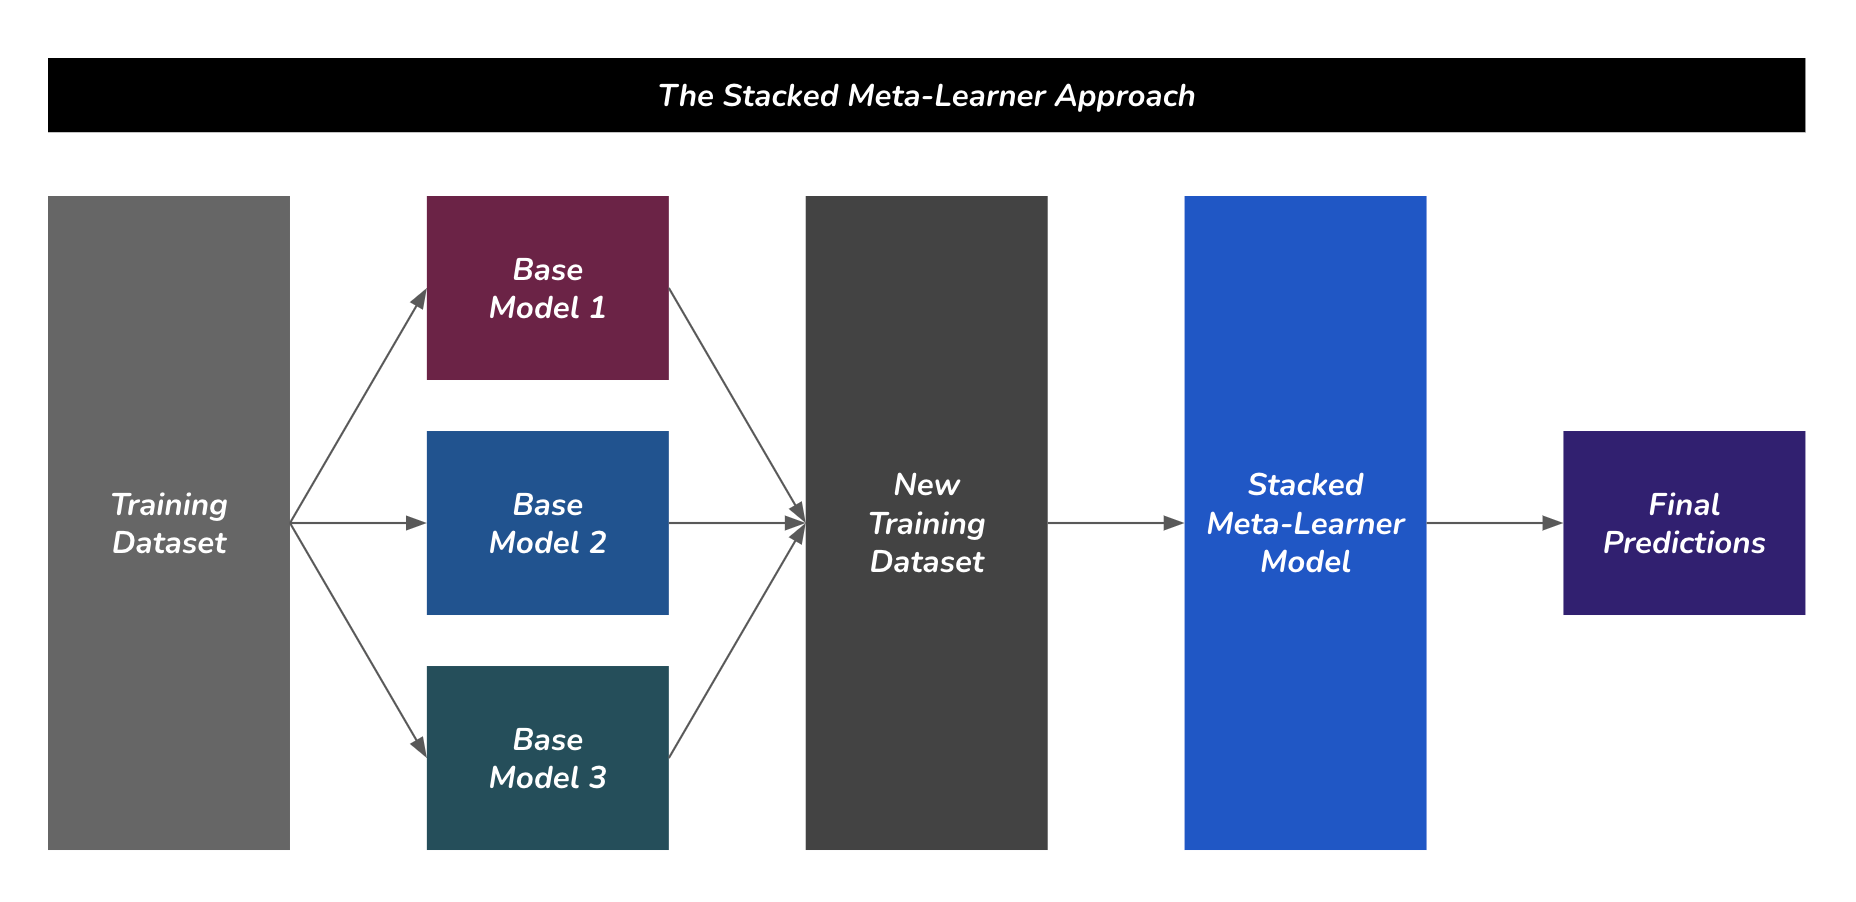

In [36]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [37]:
# Define base models
svm_base = make_pipeline(StandardScaler(), SVC(kernel='linear', random_state=42))
XGB_base = xgb.XGBClassifier(random_state=42)
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)

In [38]:
# Train base models
svm_base.fit(X_train, y_train)
XGB_base.fit(X_train, y_train)
rf_base.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [39]:
# Make predictions using base models
svm_predictions = svm_base.predict(X_test)
XGB_predictions = XGB_base.predict(X_test)
rf_predictions = rf_base.predict(X_test)

# Combine base model predictions into a meta-learner input
meta_learner_input = pd.DataFrame({'SVM': svm_predictions, 'XGB': XGB_predictions, 'RF': rf_predictions})

# Define meta-learner
meta_learner =  xgb.XGBClassifier(random_state=42)
meta_learner.fit(meta_learner_input, y_test)

# Make predictions using the meta-learner
meta_learner_predictions = meta_learner.predict(meta_learner_input)


In [40]:
# Evaluate the model

# Calculate accuracy
accuracy = accuracy_score(y_test, meta_learner_predictions)
print("Accuracy:", accuracy)

# Calculate F1-score
f1 = f1_score(y_test, meta_learner_predictions)
print("F1-score:", f1)

Accuracy: 0.9552
F1-score: 0.9607568325157675


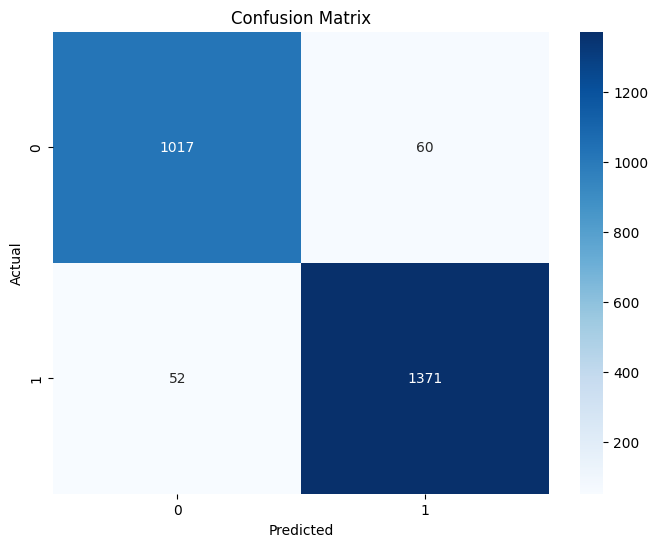

In [41]:
conf_matrix = confusion_matrix(y_test, meta_learner_predictions)

# Plot the confusion matrix using seaborn and matplotlib
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

- As we can see, through this Ensemble Machine Learning approach, we've been able to **further improve the model's predictive performance to 95.52% Accuracy and 96.07% F1-Score.**



## **Key Takeaways**

In this notebook, **we have gone beyond the typical NLP Machine Learning pipeline** and used a **couple of additional methods** to push up the performance of our modeling even further:

1. **A Hybrid Machine Learning Approach** on Tabular Features + Text Content
2. **A Stacked Meta-Learning Approach on the Hybrid** Tabular Features + Text Con
tent

Another important takeaway is that while binary classification can be a relatively easier area for simple Text Preprocessing/Vectorization and Machine Learning models to perform well, **there are more complex NLP problem statements such as Multi-class Classification and Text Generation**, where more sophisticated approaches will be required.

While we will delve into more powerful ideas and methods in the upcoming weeks that focus on extracting the Semantic Meaning of Text, (and this is undoubtedly the biggest lever for a model to perform well in NLP) it is worth keeping in mind that every single approach is a potential tool in the toolbox, and the standard industry approach is often to hedge bets and use Ensemble methods that can combine the best of multiple ways of working.
